In [1]:
!pip install --quiet norse 
!pip install --quiet torch
!pip install --quiet torchvision

     |████████████████████████████████| 92kB 11.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
% cd "/content/drive/MyDrive/Norse SNN/Speach/"
% ls

/content/drive/MyDrive/Norse SNN/Speach
 checkpoints/
'CNN Russian_Speach_Digit_0-9.ipynb'
'code 3conv zeros.ipynb'
'code Russian digit 99 %.ipynb'
'code Speech command comm.ipynb'
'code Speech command digits.ipynb'
'code Speech TIMIT phoneme.ipynb'
'code Speech TIMIT spec phoneme.ipynb'
'code Speech TIMIT words.ipynb'
 data/
 NB/
'Quant code Speech commands digits.ipynb'
'Quant code Speech Russian digits.ipynb'
'Quant code Speech TIMIT words.ipynb'
'Копия code 3conv zeros.ipynb'
'Копия code.ipynb'


In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, random_split


import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms


import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

#norse
import norse
from norse.torch import LIFCell, LILinearCell  
from norse.torch.module import LILinearCell, LIFParameters, LIState, LIFFeedForwardState, SequentialState, LICell

from norse.torch.module.encode  import ConstantCurrentLIFEncoder, PoissonEncoder, SpikeLatencyLIFEncoder


from typing import NamedTuple



In [5]:
BATCH_SIZE = 50
T = 48
LR = 0.001

RAND_SEED = 0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('select device:', DEVICE)

select device: cuda


## Dataset


### transforms

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13,), (0.2,)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13,), (0.2,)),
])

### Data loader

In [7]:
def load_split_train_test(datadir = "./data/Russian_Speach_Digit_0-9 (spec, low)", valid_size = .2, batch_size=BATCH_SIZE):
    print('batch_size', batch_size)

    model_dataset = ImageFolder(datadir, 
                                transform= transforms.Compose([
                                                       transforms.Resize(28),
                                                       transforms.ToTensor(),
                                                       transforms.Normalize((0.13,), (0.3,)),
                                                     ])) 

    total_size = len(model_dataset)
    test_size  = int(valid_size*total_size)


    train_dataset,  test_dataset = random_split(model_dataset, [total_size-test_size, test_size], generator=torch.manual_seed(RAND_SEED))

    return DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),\
           DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False), model_dataset.classes

### Info

In [8]:
dtype = torch.float16

train_loader, test_loader, classes = load_split_train_test('./data/speech_commands_v0.02 (spec) (digit, 2_5)')
img, _ = train_loader.dataset[0]

print('classes:', classes)
print('train loader size:', len(train_loader))

batch_size 50
classes: ['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three', 'two', 'zero']
train loader size: 400


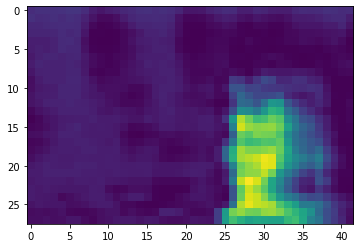

In [9]:
plt.imshow(train_loader.dataset[11][0][0])

## Encode

In [10]:
def plot_spikes_2d(fig, z):
    T = z.shape[0]
    C = z.shape[1]

    fig.set_size_inches(10,8)
    for c in range(C):
        ax = fig.add_subplot(1, C, c+1, projection='3d')
        s = z[:,c].detach().to_sparse().coalesce()

        ax.invert_yaxis()
        ax.invert_zaxis()
        ax.set_xlim([0,T])
        ax.set_xlabel('time [ms]')
        ax.set_ylabel('spectrogram time')
        ax.set_zlabel('spectrogram Hz')
        ax.scatter(s.indices()[0], s.indices()[2], s.indices()[1], s=1.0, c=s.values())

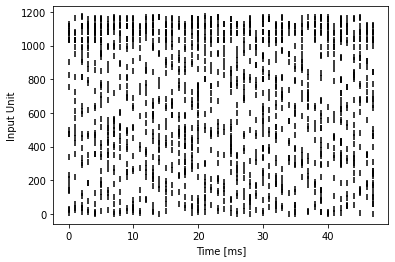

In [11]:
example_encoder = PoissonEncoder(T)


example_input = example_encoder(img[0])
example_spikes = example_input.reshape(T,img.shape[1]*img.shape[2]).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

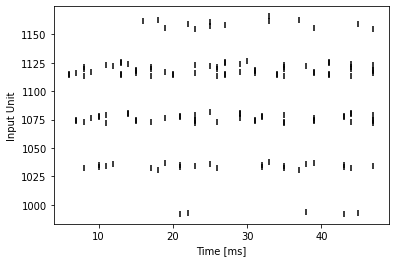

In [12]:
example_encoder = ConstantCurrentLIFEncoder(T)

example_input = example_encoder(img[0])
example_spikes = example_input.reshape(T,img.shape[1]*img.shape[2]).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

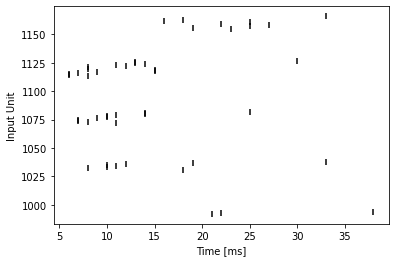

In [13]:
example_encoder = SpikeLatencyLIFEncoder(T)

example_input = example_encoder(img[0])
example_spikes = example_input.reshape(T,img.shape[1]*img.shape[2]).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

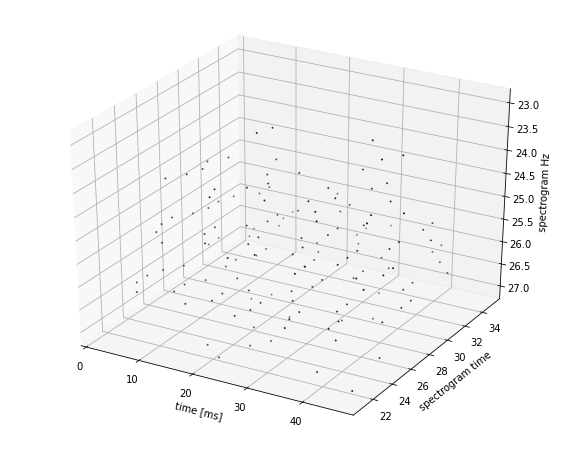

In [14]:
example_encoder = ConstantCurrentLIFEncoder(T)

example_input = example_encoder(img[0].reshape((1, img.shape[1], img.shape[2])))


fig = plt.figure()

plot_spikes_2d(fig, example_input)

## Convolutional Networks


### CNNs

In [15]:
class CNN(nn.Module):

  def __init__(self): 
         super(CNN, self).__init__() 
         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

         self.convlayer1 = nn.Sequential( 
                              nn.Conv2d(32, 64, kernel_size=3, padding=1), 
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.convlayer2 = nn.Sequential( 
                              nn.Conv2d(64, 96, kernel_size=3, padding=1), 
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.fclayer1 = nn.Linear(6720, 2048)
         
      

         self.out = nn.Linear(2048, 10)

  def forward(self, x): 
         out = self.conv1(x) 
         out = self.convlayer1(out) 
         out = self.convlayer2(out) 
         out = out.reshape(out.size(0), -1) 
         #print(out.shape)

         out = self.fclayer1(out) 


         return self.out(out)


In [16]:
class CNN2(nn.Module):

  def __init__(self): 
         super(CNN2, self).__init__() 


         self.conv1 = nn.Sequential( 
                              nn.Conv2d(3, 64, kernel_size=3), 
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         
         self.conv2 = nn.Sequential( 
                              nn.Conv2d(64, 96, kernel_size=3), 
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.conv3 = nn.Sequential( 
                              nn.Conv2d(96, 128, kernel_size=3), 
                              nn.ReLU(),
                              #nn.MaxPool2d(kernel_size=2)
                              ) 
         

         self.drop_out = nn.Dropout() 

         self.fclayer1 = nn.Linear(2048, 768)


        

         self.out = nn.Linear(768, 10)

  def forward(self, x): 
         out = self.conv1(x) 

         out = self.conv2(out) 

         out = self.conv3(out) 

         out = out.reshape(out.size(0), -1) 
         out = self.drop_out(out) 
         #print(out.shape)

         out = self.fclayer1(out) 


         return self.out(out)


### SNNs

In [17]:
class Model(nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn     = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [18]:
class SCNN(nn.Module):
    def __init__(
        self,  num_channels = 1, classes = 10, 
        input_size = (28, 28), kernel_size = 3, 
        method="super", alpha=100, 
    ):
        super(SCNN, self).__init__()

        #### -- ####
        self.lif_param = LIFParameters(method=method, alpha=alpha)
        self.features =  torch.tensor(input_size).int()
        self.max_pool2d = torch.nn.MaxPool2d(2)

        self.features2 = None


        print(self.features)

        #### Conv2D ####
        self.conv1 = torch.nn.Conv2d(num_channels, 64, kernel_size, 1)
        self.lif0 = LIFCell(p=LIFParameters(method=method, alpha=alpha))

        #self.features =   (self.features - (kernel_size - 1) ).int()

        #        MaxPool2d(2)
        self.features =   ((self.features -(kernel_size - 1) - 2)/2 + 1).short()
        self.features1 = self.features
        print(self.features)


        self.conv2 = torch.nn.Conv2d(self.conv1.out_channels, 96, kernel_size, 1)
        self.lif1 = LIFCell(p=LIFParameters(method=method, alpha=alpha))

        #self.features =   (self.features - (kernel_size - 1) ).int()

        #        MaxPool2d(2)
        self.features =   ((self.features -(kernel_size - 1) - 2)/2 + 1).short()
        self.features2 = self.features
        print(self.features)


        #### FC ####
        self.features = self.features[0] * self.features[1] * self.conv2.out_channels

        self.fc1 = torch.nn.Linear(self.features, int(self.features/4))
        self.lif2 = LIFCell(p=LIFParameters(method=method, alpha=alpha))

        #### Out ####
        self.out = LILinearCell(int(self.features/4), 10)

    def forward(self, x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]
        
        # specify the initial states
        s0 = s1 = s2 = s3 = s4 = so = None

        voltages = torch.zeros(
            seq_length, batch_size, 10, device=x.device, dtype=x.dtype
        )


        self.z_tmp_1 = torch.zeros(
            seq_length, batch_size, self.conv1.out_channels, self.features1[0], self.features1[1], device=x.device, dtype=x.dtype
        ) 


        self.z_tmp_2 = torch.zeros(
            seq_length, batch_size, self.conv2.out_channels, self.features2[0], self.features2[1], device=x.device, dtype=x.dtype
        ) 


        self.z_tmp_fc = torch.zeros(
            seq_length, batch_size, self.fc1.out_features, device=x.device, dtype=x.dtype
        )         
        for ts in range(seq_length):

            z, s0 = self.lif0(10*self.conv1(x[ts, :]), s0)
            z = self.max_pool2d(z)

            self.z_tmp_1[ts, ...] = z 

            z, s1 = self.lif1(self.conv2(z), s1)
            z = self.max_pool2d(z)

            self.z_tmp_2[ts, ...] = z


            z = z.view(-1, self.features)


            z, s3 = self.lif2(self.fc1(z), s3)

            self.z_tmp_fc[ts, ...] = z



            voltages[ts, :, :], so = self.out(z, so)


        return voltages

In [19]:
def decode(x):
    x, _ = torch.max(x, 0)
    return F.log_softmax(x)

## Train test

In [20]:
L_acc  = []
L_loss = []

In [21]:
def evalute(model, test_loader):
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for img, target in tqdm(test_loader):
          
            out = model(img.to(DEVICE))
            
            pred = out.max(1)[1].detach().cpu().numpy()
            target = target.cpu().numpy()
            correct += (pred==target).sum()
            total += len(target)


    return 100*correct / total

In [22]:
def train(model, train_loader, optimizer):
      model.train()
      for img, target in tqdm(train_loader):
          img, target = img.to(DEVICE), target.to(DEVICE)

          optimizer.zero_grad()

          out = model(img)

          loss = F.nll_loss(out, target)
          
          loss.backward()

          optimizer.step()

      return loss.item() 

In [23]:
def train_test_loop(model, train_loader, test_loader, opt = 'SGD', EPOCH = 1, lr = 0.01, momentum=0.9 ):
    print('Train model')
    
    if opt == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=1e-4)
    elif opt == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
      print('Unknown optim', opt)


    model.to(DEVICE)

    best_acc = evalute(model, test_loader)
    print('\nAccuracy now: ', best_acc)
    L_acc.append(best_acc)
    
    for epoch in range(1,EPOCH+1):
        print("\nEpoch %d/%d"%(epoch, EPOCH))

        loss = train(model, train_loader, optimizer)
        L_loss.append(loss)
        
        acc = evalute(model, test_loader)
        L_acc.append(acc)
        
        print("Accuracy: ", acc)

        if best_acc < acc:
          print('Save', best_acc,'-->', acc)
          torch.save( model, './checkpoints/CNN digits cp.pth')
          best_acc = acc
          
        print()

    model = torch.load('./checkpoints/CNN digits cp.pth')
    print("\nBest Acc=%.4f"%(best_acc))

## Train test loop

In [24]:
model = Model(
    encoder= ConstantCurrentLIFEncoder(T),
    snn=SCNN(num_channels = img.shape[0], classes = len(classes), input_size = img[0].shape),
    decoder=decode
).to(DEVICE)



tensor([28, 42], dtype=torch.int32)
tensor([13, 20], dtype=torch.int16)
tensor([5, 9], dtype=torch.int16)


In [ ]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 10, lr = LR/2)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  10.86

Epoch 1/10



Accuracy:  56.76
Save 10.86 --> 56.76


Epoch 2/10



Accuracy:  68.36
Save 56.76 --> 68.36


Epoch 3/10



Accuracy:  71.8
Save 68.36 --> 71.8


Epoch 4/10



Accuracy:  75.8
Save 71.8 --> 75.8


Epoch 5/10



Accuracy:  78.22
Save 75.8 --> 78.22


Epoch 6/10



Accuracy:  77.12


Epoch 7/10



Accuracy:  79.8
Save 78.22 --> 79.8


Epoch 8/10



Accuracy:  81.5
Save 79.8 --> 81.5


Epoch 9/10



Accuracy:  82.04
Save 81.5 --> 82.04


Epoch 10/10



Accuracy:  83.5
Save 82.04 --> 83.5


Best Acc=83.5000


In [ ]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 5, lr = LR/10)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  83.5

Epoch 1/5



Accuracy:  84.5
Save 83.5 --> 84.5


Epoch 2/5



Accuracy:  84.62
Save 84.5 --> 84.62


Epoch 3/5



Accuracy:  84.44


Epoch 4/5



Accuracy:  84.94
Save 84.62 --> 84.94


Epoch 5/5



Accuracy:  85.02
Save 84.94 --> 85.02


Best Acc=85.0200


Колаб отключился, пришлось перезапускать и склеивать процессы.

In [27]:
L_acc_1 = [10.86, 56.76, 68.36, 71.8, 75.8, 78.22, 77.12, 79.8, 81.5, 82.04, 83.5]

In [28]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 5, lr = LR/15)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  84.98

Epoch 1/5



Accuracy:  85.18
Save 84.98 --> 85.18


Epoch 2/5



Accuracy:  84.8


Epoch 3/5



Accuracy:  85.42
Save 85.18 --> 85.42


Epoch 4/5



Accuracy:  85.26


Epoch 5/5



Accuracy:  85.46
Save 85.42 --> 85.46


Best Acc=85.4600


In [29]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 5, lr = LR/20)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  85.46

Epoch 1/5



Accuracy:  85.44


Epoch 2/5



Accuracy:  85.66
Save 85.46 --> 85.66


Epoch 3/5



Accuracy:  86.02
Save 85.66 --> 86.02


Epoch 4/5



Accuracy:  85.7


Epoch 5/5



Accuracy:  85.66


Best Acc=86.0200


In [54]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 5, lr = LR/26)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  86.02

Epoch 1/5



Accuracy:  85.62


Epoch 2/5



Accuracy:  85.3


Epoch 3/5



Accuracy:  85.78


Epoch 4/5



Accuracy:  85.8


Epoch 5/5



Accuracy:  85.78


Best Acc=86.0200


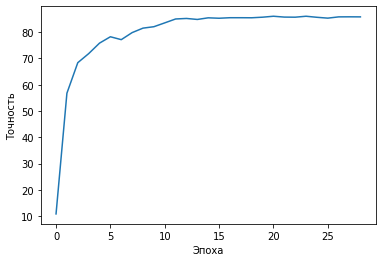

In [55]:
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.plot(L_acc_1+L_acc)

In [ ]:
''' Не удалось сохранить
plt.xlabel("Эпоха")
plt.ylabel("nll_loss")
plt.plot(L_loss)
'''

In [59]:
model = torch.load('./checkpoints/CNN digits cp.pth')
evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


86.02

In [60]:
evalute(model, train_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


95.025

### Quant

In [61]:
def sign(x):
  if x == 0: return 0 
  return 1 if x>0 else -1

L = 4

def Quant(weight, levels = 4):
  dev = weight.device
  D = weight.max().item()/(levels - 1)
  W = weight.clone().detach().cpu() 
  for k in range(levels):
    W.apply_(lambda x: k*D*sign(x) if k < sign(x)*x/D < k+1 else x)

  return W.to(dev)



In [62]:
model = torch.load('./checkpoints/CNN digits cp.pth')

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


86.02

In [63]:
L = 4

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


13.34

In [64]:
model = torch.load('./checkpoints/CNN digits cp.pth')

In [65]:
L = 5

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


33.52

In [66]:
model = torch.load('./checkpoints/CNN digits cp.pth')

In [67]:
L = 6

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


56.24

In [68]:
model = torch.load('./checkpoints/CNN digits cp.pth')

In [69]:
L = 8

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


69.7

In [70]:
model = torch.load('./checkpoints/CNN digits cp.pth')

In [71]:
L = 16

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


83.3

In [72]:
model = torch.load('./checkpoints/CNN digits cp.pth')

In [73]:
L = 32

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


85.5

In [74]:
model = torch.load('./checkpoints/CNN digits cp.pth')

In [75]:
L = 64

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


85.62

In [76]:
model = torch.load('./checkpoints/CNN digits cp.pth')

In [77]:
L = 128

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


85.76

In [78]:
model = torch.load('./checkpoints/CNN digits cp.pth')

In [79]:
L = 256

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


85.88

In [80]:
model = torch.load('./checkpoints/CNN digits cp.pth')

In [81]:
L = 512

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


85.74